In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
import time
from matplotlib.animation import FuncAnimation
import time

class SpectrumEnvironment:
    def __init__(self, num_bands=10, steps=25):
        self.num_bands = num_bands  # Total number of frequency bands
        self.steps = steps
        self.channel_states = [[] for _ in range(num_bands)]
        self.transition_matrices = self._initialize_transition_matrices()
        self.state = self._generate_spectrum_state()  # Current state of the spectrum
        self.total_reward = 0  # Track total reward
        self.rewards = []  # Track rewards for each step
        self.energy_costs = [[] for _ in range(num_bands)]

    def _initialize_transition_matrices(self):
        """
        Generate a unique random Markov chain transition matrix for each band.
        Each matrix ensures that the probabilities in each row sum to 1.
        """
        matrices = []
        for _ in range(self.num_bands):
            # Generate a random 2x2 matrix
            random_matrix = np.random.rand(2, 2)
            # Normalize each row to sum to 1
            transition_matrix = random_matrix / random_matrix.sum(axis=1, keepdims=True)
            matrices.append(transition_matrix)
        return matrices

    def _generate_spectrum_state(self):
        """
        Generate a spectrum state using Markov chain dynamics for each band.
        Each band has a distinct transition matrix and evolves over 'steps' timesteps.
        """
        new_states = []

        for band in range(self.num_bands):
            # Get the last state or default to 0 if no history exists
            last_state = self.channel_states[band][-1] if self.channel_states[band] else 0

            # Generate states for the next 'steps' timesteps using the Markov chain
            band_states = []
            for _ in range(self.steps):
                # Determine the next state based on the Markov chain
                transition_probabilities = self.transition_matrices[band][last_state]
                next_state = np.random.choice([0, 1], p=transition_probabilities)
                band_states.append(next_state)
                last_state = next_state  # Update for the next step

            # Append the generated states to history
            self.channel_states[band] = band_states
        return self.channel_states
    
    def energy_detection(self, time_step, band, delta=0.1):
        """
        Perform energy detection for a specific band and timestep.
        Calculates energy dynamically and assigns rewards based on the state and energy detection.

        Parameters:
        - time_step (int): The timestep to evaluate.
        - band (int): The band (channel) number to evaluate.
        - delta (float): The change in energy state for transitions (default: 0.1).

        Returns:
        - reward (int): The reward calculated based on energy detection and the channel state.
        """
        # Ensure the inputs are within valid ranges
        if not (0 <= band < self.num_bands):
            raise ValueError("Band number out of range.")
        if not (0 <= time_step < self.steps):
            raise ValueError("Time step out of range.")

        # Current state of the channel
        current_state = self.channel_states[band][time_step]

        # Retrieve previous energy state (default to 0 if no previous energy state)
        previous_energy = self.energy_costs[band][-1] if len(self.energy_costs[band]) > 0  else 0

        # Calculate new energy state
        if current_state == 1:
            # Increase energy by delta if the state is 1
            new_energy = previous_energy + delta
        else:
            # No change in energy if the state is 0
            new_energy = previous_energy

        self.energy_costs[band].append(new_energy)
        return new_energy

    def matched_filter_fft(self, band, time_step):
        """
        Simulates matched filter detection using FFT with adaptive energy consumption.
        Energy consumption is higher for detecting occupied states (state = 1).
        
        Parameters:
        - band (int): The band (channel) to evaluate.
        - time_step (int): The time step for the evaluation.

        Returns:
        - energy_consumption (float): The energy consumed by the matched filter detection.
        """
        # Ensure inputs are valid
        if not (0 <= band < self.num_bands):
            raise ValueError("Band number out of range.")
        if not (0 <= time_step < self.steps):
            raise ValueError("Time step out of range.")

        # Current state of the channel
        current_state = self.channel_states[band][time_step]

        # Base energy consumption for matched filter detection
        base_energy = 0.2

        # Additional energy cost based on the state (higher for state = 1)
        state_energy = 0.1 if current_state == 1 else 0.05

        # Add an energy cost for history length as in a Markov process
        sensing_history_length = len(self.energy_costs[band])
        history_energy = 0.02 * sensing_history_length

        # Total energy consumption
        total_energy_consumption = base_energy + state_energy + history_energy

        # Update energy costs history for this band
        self.energy_costs[band].append(total_energy_consumption)

        return total_energy_consumption


    def cyclostationary_detection(self, band, time_step):
        """
        Simulates cyclostationary feature detection based on periodic properties.
        Energy consumption is moderate and depends on the band state and history.
        
        Parameters:
        - band (int): The band (channel) to evaluate.
        - time_step (int): The time step for the evaluation.

        Returns:
        - energy_consumption (float): The energy consumed by cyclostationary detection.
        """
        # Ensure inputs are valid
        if not (0 <= band < self.num_bands):
            raise ValueError("Band number out of range.")
        if not (0 <= time_step < self.steps):
            raise ValueError("Time step out of range.")

        # Current state of the channel
        current_state = self.channel_states[band][time_step]

        # Base energy consumption for cyclostationary detection
        base_energy = 0.15

        # Additional energy cost based on the state (higher for state = 1)
        state_energy = 0.07 if current_state == 1 else 0.03

        # Add an energy cost for history length as in a Markov process
        sensing_history_length = len(self.energy_costs[band])
        history_energy = 0.015 * sensing_history_length

        # Total energy consumption
        total_energy_consumption = base_energy + state_energy + history_energy

        # Update energy costs history for this band
        self.energy_costs[band].append(total_energy_consumption)

        return total_energy_consumption



    def step(self, time_step, band):
        """
        Calculate the reward based on the state of a given channel at a specific timestep.
        
        Parameters:
        - time_step (int): The time step to evaluate.
        - band (int): The band (channel) number to evaluate.
        
        Returns:
        - reward (int): The reward gained from the channel's state at the specified time step.
        """
        # Ensure the inputs are within valid ranges
        if not (0 <= band < self.num_bands):
            raise ValueError("Band number out of range.")
        if not (0 <= time_step < self.steps):
            raise ValueError("Time step out of range.")

        # Get the state of the specified channel at the given timestep
        state = self.channel_states[band][time_step]

        # Calculate the reward
        reward = 30 if state == 0 else -15

        # Update the total reward and track the step reward
        self.total_reward += reward
        self.rewards.append(reward)

        return reward

In [2]:
# Initialize environment
env = SpectrumEnvironment(num_bands=10, steps=50)

# Generate states for all bands
env._generate_spectrum_state()

# Store rewards, actions, and energy costs for visualization
rewards_over_time = []
actions_over_time = []
energy_costs = [[0 for _ in range(env.steps)] for _ in range(env.num_bands)]  # Initialize with None

# Simulate over timesteps
for t in range(env.steps):
    # Perform energy detection
    for selected_band in range(env.num_bands):
        energy = env.cyclostationary_detection(selected_band, t)

time_steps = np.arange(env.steps)

for i in range(env.num_bands): 
    print(env.energy_costs[i])


[0.18, 0.195, 0.25, 0.265, 0.24, 0.295, 0.31, 0.325, 0.33999999999999997, 0.355, 0.37, 0.385, 0.4, 0.41500000000000004, 0.43, 0.40499999999999997, 0.42, 0.435, 0.49, 0.505, 0.52, 0.495, 0.51, 0.5249999999999999, 0.54, 0.5549999999999999, 0.5700000000000001, 0.585, 0.6, 0.655, 0.6699999999999999, 0.6849999999999999, 0.7, 0.715, 0.73, 0.745, 0.76, 0.7749999999999999, 0.7899999999999999, 0.8049999999999999, 0.82, 0.835, 0.85, 0.865, 0.8799999999999999, 0.8949999999999999, 0.9099999999999999, 0.9249999999999999, 0.94, 0.915]
[0.18, 0.195, 0.25, 0.22499999999999998, 0.24, 0.255, 0.27, 0.325, 0.3, 0.315, 0.32999999999999996, 0.385, 0.36, 0.375, 0.39, 0.44499999999999995, 0.42, 0.435, 0.45, 0.505, 0.48, 0.495, 0.5499999999999999, 0.5249999999999999, 0.58, 0.5549999999999999, 0.5700000000000001, 0.585, 0.64, 0.615, 0.6699999999999999, 0.645, 0.6599999999999999, 0.715, 0.69, 0.745, 0.72, 0.7349999999999999, 0.75, 0.7649999999999999, 0.82, 0.7949999999999999, 0.85, 0.825, 0.8799999999999999, 0.8

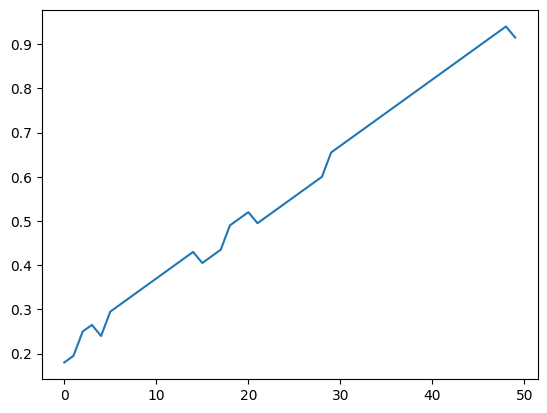

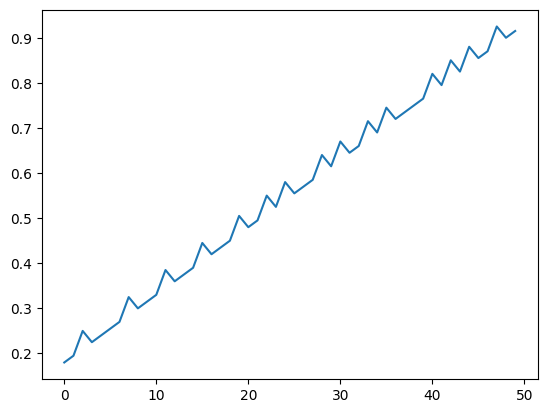

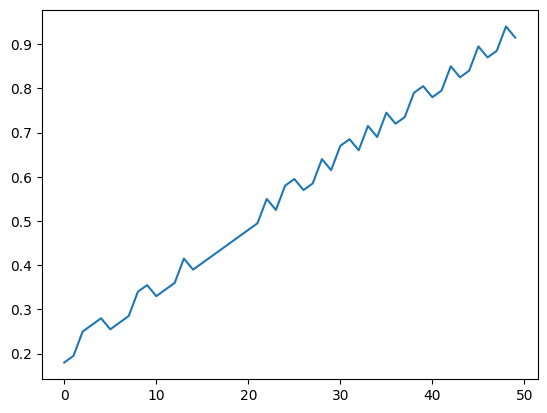

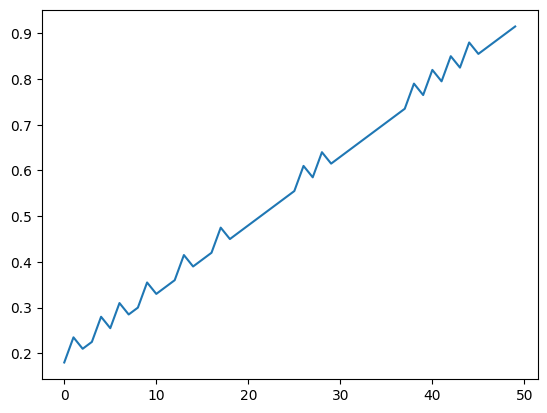

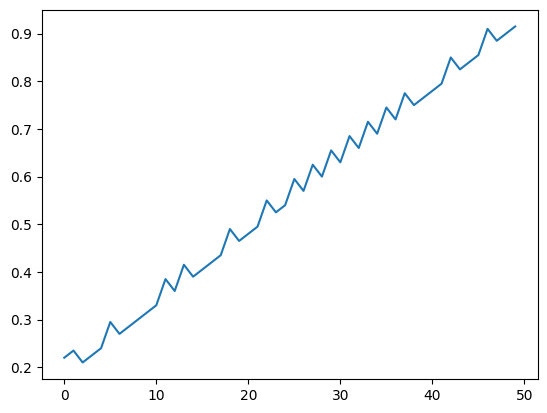

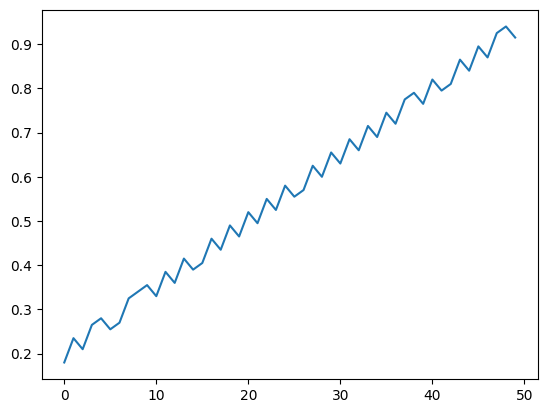

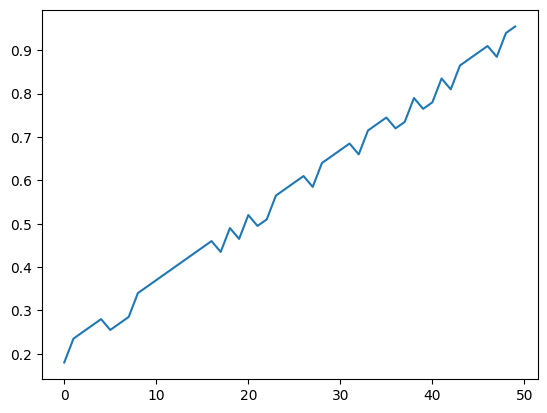

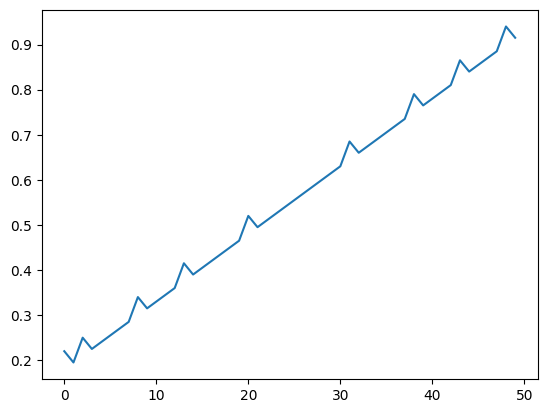

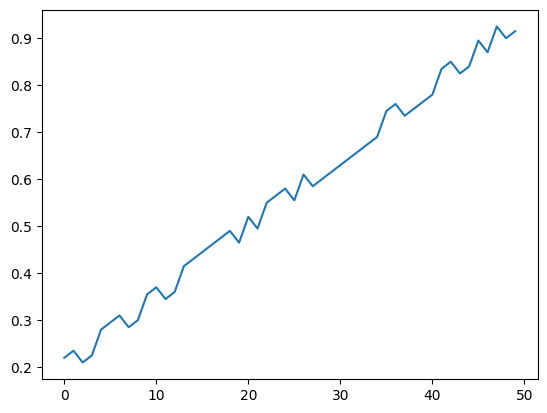

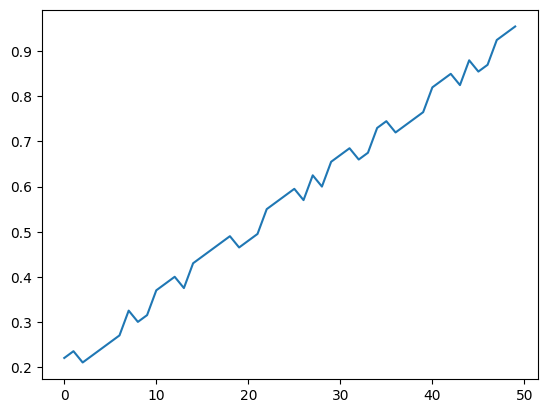

In [3]:

for i in range(env.num_bands):
    plt.plot(range(env.steps), env.energy_costs[i])
    plt.show()
    plt.close()

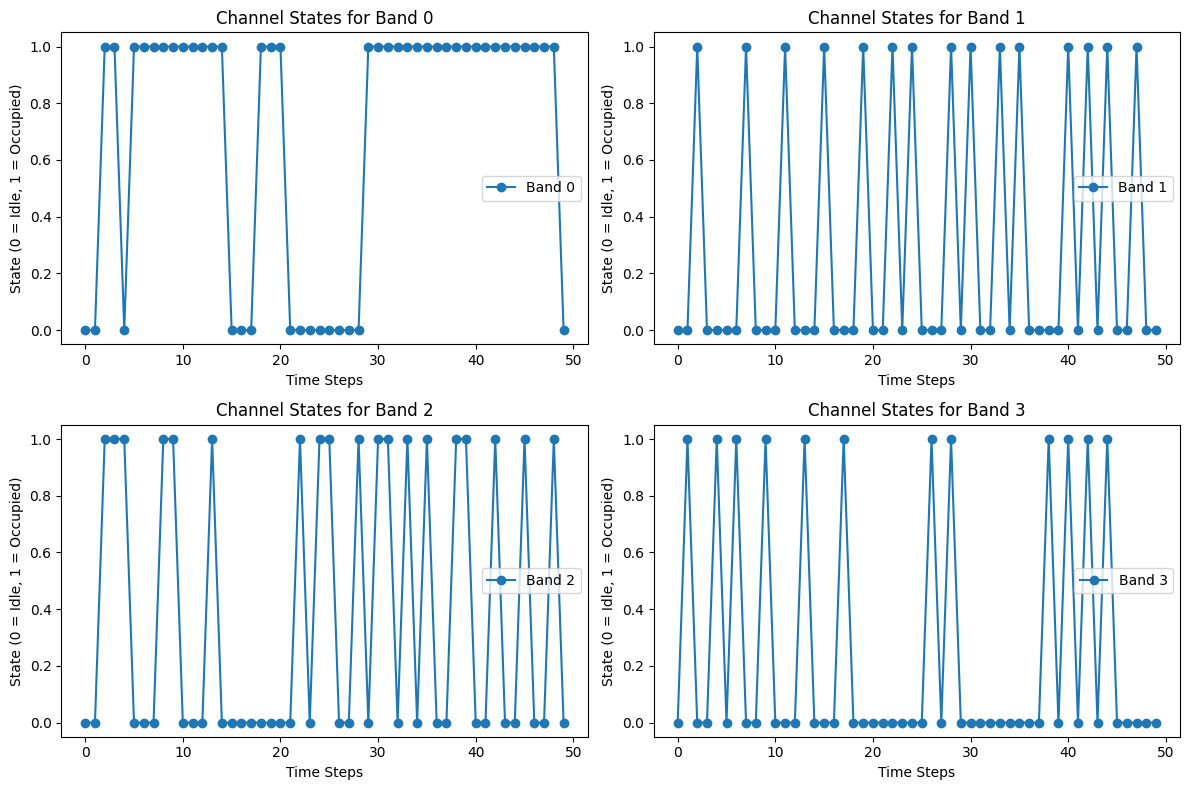

In [4]:
# Visualization of channel states for 4 selected bands
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # Create a 2x2 grid of subplots
selected_bands = [0, 1, 2, 3]  # Indices of bands to visualize

for i, band in enumerate(selected_bands):
    ax = axes[i // 2, i % 2]  # Access subplot in 2x2 grid
    states = [env.channel_states[band][t] for t in range(env.steps)]
    ax.plot(time_steps, states, label=f"Band {band}", marker='o')
    ax.set_xlabel("Time Steps")
    ax.set_ylabel("State (0 = Idle, 1 = Occupied)")
    ax.set_title(f"Channel States for Band {band}")
    ax.legend()

plt.tight_layout()
plt.show()


In [5]:
import numpy as np

class QLearningAgent:
    def __init__(self, environment, alpha=0.1, gamma=0.9, epsilon=0.2):
        """
        Initialize the Q-learning agent.
        
        Parameters:
        - environment: The SpectrumEnvironment object.
        - alpha (float): Learning rate.
        - gamma (float): Discount factor.
        - epsilon (float): Exploration probability.
        """
        self.env = environment
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        
        # Q-table: States are (time_step, band), actions are bands
        self.q_table = np.zeros((self.env.steps, self.env.num_bands))
        
    def choose_action(self, state):
        """
        Choose an action based on epsilon-greedy policy.
        
        Parameters:
        - state (tuple): The current state (time_step).
        
        Returns:
        - action (int): The selected band (channel).
        """
        time_step = state[0]
        
        if np.random.rand() < self.epsilon:
            # Exploration: Randomly select a band
            return np.random.randint(0, self.env.num_bands)
        else:
            # Exploitation: Select the band with the highest Q-value
            return np.argmin(self.q_table[time_step])
    
    def update_q_table(self, state, action, reward, next_state):
        """
        Update the Q-value for a given state-action pair.
        
        Parameters:
        - state (tuple): The current state (time_step).
        - action (int): The chosen action (band).
        - reward (float): The reward received.
        - next_state (tuple): The next state (time_step + 1).
        """
        time_step = state[0]
        next_time_step = next_state[0]
        
        # Get the maximum Q-value for the next state
        max_next_q = np.min(self.q_table[next_time_step])  # Minimize energy
        
        # Update the Q-value using the Q-learning formula
        self.q_table[time_step, action] += self.alpha * (
            reward + self.gamma * max_next_q - self.q_table[time_step, action]
        )
    
    def train(self, episodes):
        """
        Train the agent over multiple episodes.
        
        Parameters:
        - episodes (int): Number of episodes to train the agent.
        """
        for episode in range(episodes):
            print(f"Episode {episode + 1}/{episodes}")
            
            # Reset the environment for each episode
            self.env._generate_spectrum_state()
            total_reward = 0
            
            # Start at the first timestep
            for time_step in range(self.env.steps - 1):
                state = (time_step,)
                
                # Choose an action (band)
                action = self.choose_action(state)
                
                # Calculate energy dynamically (decided by Q-learning)
                energy = self.env.energy_detection(time_step, action)
                
                # Calculate the reward (penalize based on energy)
                raw_reward = self.env.step(time_step, action)
                reward = raw_reward - energy
                
                # Move to the next state
                next_state = (time_step + 1,)
                
                # Update Q-table
                self.update_q_table(state, action, reward, next_state)
                
                # Track the total reward for the episode
                total_reward += reward
            
            print(f"Total Reward for Episode {episode + 1}: {total_reward}")

# Example Usage
env = SpectrumEnvironment(num_bands=5, steps=10)
agent = QLearningAgent(env)

# Train the agent
agent.train(episodes=500)

# Display the Q-table
# print("Q-Table:")
# print(agent.q_table)


Episode 1/500
Total Reward for Episode 1: 88.49999999999999
Episode 2/500
Total Reward for Episode 2: 87.6
Episode 3/500
Total Reward for Episode 3: -48.0
Episode 4/500
Total Reward for Episode 4: -95.89999999999998
Episode 5/500
Total Reward for Episode 5: -54.6
Episode 6/500
Total Reward for Episode 6: 123.6
Episode 7/500
Total Reward for Episode 7: 32.699999999999996
Episode 8/500
Total Reward for Episode 8: 33.49999999999998
Episode 9/500
Total Reward for Episode 9: -59.7
Episode 10/500
Total Reward for Episode 10: 31.699999999999996
Episode 11/500
Total Reward for Episode 11: -152.70000000000002
Episode 12/500
Total Reward for Episode 12: -24.100000000000012
Episode 13/500
Total Reward for Episode 13: 22.29999999999999
Episode 14/500
Total Reward for Episode 14: 65.49999999999999
Episode 15/500
Total Reward for Episode 15: -73.9
Episode 16/500
Total Reward for Episode 16: 69.89999999999998
Episode 17/500
Total Reward for Episode 17: -29.500000000000004
Episode 18/500
Total Reward 

Episode 1/500: Reward = 134.00000000000003, Energy = 1.0
Episode 2/500: Reward = 133.5, Energy = 1.5000000000000002
Episode 3/500: Reward = 222.60000000000002, Energy = 2.4000000000000004
Episode 4/500: Reward = 177.2, Energy = 2.8000000000000003
Episode 5/500: Reward = 42.0, Energy = 3.0
Episode 6/500: Reward = 40.7, Energy = 4.3
Episode 7/500: Reward = 40.7, Energy = 4.3
Episode 8/500: Reward = 175.29999999999998, Energy = 4.699999999999999
Episode 9/500: Reward = 40.0, Energy = 5.0
Episode 10/500: Reward = 82.69999999999997, Energy = 7.3
Episode 11/500: Reward = 36.7, Energy = 8.299999999999999
Episode 12/500: Reward = 215.60000000000002, Energy = 9.399999999999999
Episode 13/500: Reward = 35.29999999999998, Energy = 9.7
Episode 14/500: Reward = 33.599999999999994, Energy = 11.4
Episode 15/500: Reward = -12.199999999999992, Energy = 12.200000000000001
Episode 16/500: Reward = 33.39999999999999, Energy = 11.600000000000001
Episode 17/500: Reward = 31.599999999999998, Energy = 13.4000

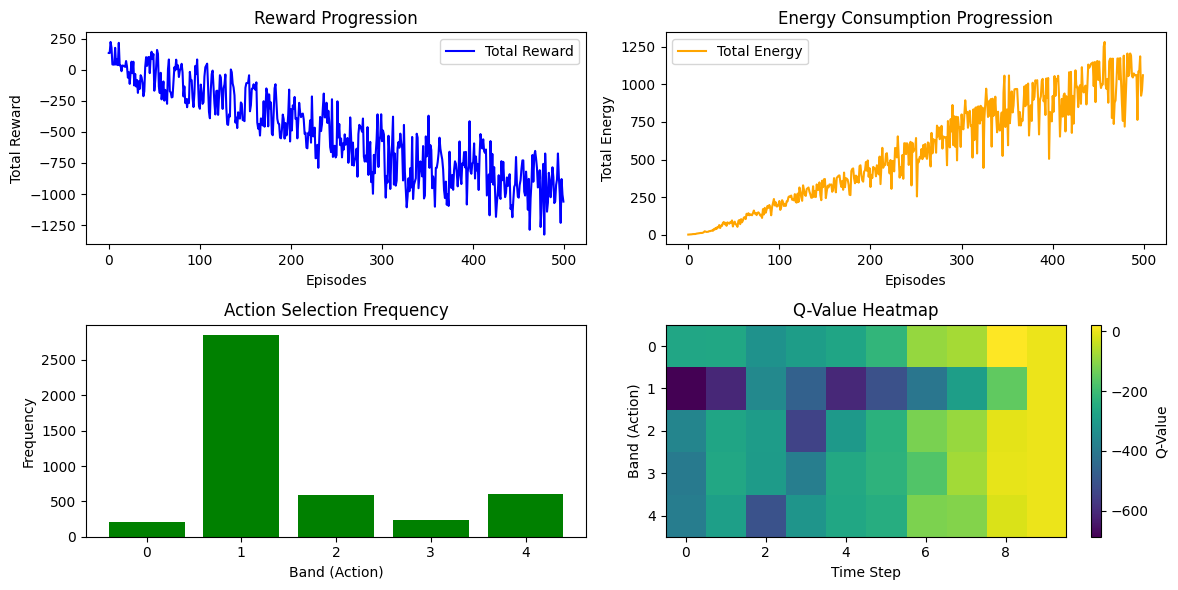

In [6]:
import matplotlib.pyplot as plt
import numpy as np

class QLearningAgentWithVisualization(QLearningAgent):
    def __init__(self, environment, alpha=0.1, gamma=0.9, epsilon=0.2):
        super().__init__(environment, alpha, gamma, epsilon)
        self.episode_rewards = []  # Track total rewards per episode
        self.episode_energy = []  # Track total energy consumption per episode
        self.action_counts = np.zeros(self.env.num_bands)  # Track action selection frequency

    def train(self, episodes):
        """
        Train the agent over multiple episodes with visualization tracking.
        
        Parameters:
        - episodes (int): Number of episodes to train the agent.
        """
        for episode in range(episodes):
            # Reset environment for each episode
            self.env._generate_spectrum_state()
            total_reward = 0
            total_energy = 0

            for time_step in range(self.env.steps - 1):
                state = (time_step,)

                # Choose an action (band)
                action = self.choose_action(state)
                self.action_counts[action] += 1  # Track action frequency

                # Calculate energy dynamically (decided by Q-learning)
                energy = self.env.energy_detection(time_step, action)
                total_energy += energy

                # Calculate the reward (penalize based on energy)
                raw_reward = self.env.step(time_step, action)
                reward = raw_reward - energy

                # Move to the next state
                next_state = (time_step + 1,)

                # Update Q-table
                self.update_q_table(state, action, reward, next_state)

                # Track the total reward
                total_reward += reward

            # Store metrics for visualization
            self.episode_rewards.append(total_reward)
            self.episode_energy.append(total_energy)

            print(f"Episode {episode + 1}/{episodes}: Reward = {total_reward}, Energy = {total_energy}")

    def visualize_results(self):
        """
        Visualize the results of training using matplotlib.
        """
        episodes = len(self.episode_rewards)

        # Plot Total Rewards per Episode
        plt.figure(figsize=(12, 6))
        plt.subplot(2, 2, 1)
        plt.plot(range(episodes), self.episode_rewards, label="Total Reward", color="blue")
        plt.xlabel("Episodes")
        plt.ylabel("Total Reward")
        plt.title("Reward Progression")
        plt.legend()

        # Plot Total Energy per Episode
        plt.subplot(2, 2, 2)
        plt.plot(range(episodes), self.episode_energy, label="Total Energy", color="orange")
        plt.xlabel("Episodes")
        plt.ylabel("Total Energy")
        plt.title("Energy Consumption Progression")
        plt.legend()

        # Plot Action Selection Frequency
        plt.subplot(2, 2, 3)
        plt.bar(range(self.env.num_bands), self.action_counts, color="green")
        plt.xlabel("Band (Action)")
        plt.ylabel("Frequency")
        plt.title("Action Selection Frequency")

        # Visualize Q-Value Evolution (Heatmap)
        plt.subplot(2, 2, 4)
        plt.imshow(self.q_table.T, aspect="auto", cmap="viridis", interpolation="nearest")
        plt.colorbar(label="Q-Value")
        plt.xlabel("Time Step")
        plt.ylabel("Band (Action)")
        plt.title("Q-Value Heatmap")

        plt.tight_layout()
        plt.show()


# Example Usage
env = SpectrumEnvironment(num_bands=5, steps=10)
agent = QLearningAgentWithVisualization(env)

# Train the agent
agent.train(episodes=500)

# Visualize the results
agent.visualize_results()


Episode 1/500: Reward = -135.37, Energy = 3.7
Episode 2/500: Reward = -135.89, Energy = 8.9
Episode 3/500: Reward = -46.3, Energy = 13.000000000000004
Episode 4/500: Reward = -46.480000000000004, Energy = 14.800000000000004
Episode 5/500: Reward = -92.16000000000001, Energy = 21.60000000000001
Episode 6/500: Reward = -2.619999999999994, Energy = 26.20000000000001
Episode 7/500: Reward = -92.28, Energy = 22.80000000000001
Episode 8/500: Reward = -47.68, Energy = 26.8
Episode 9/500: Reward = -92.57000000000001, Energy = 25.699999999999992
Episode 10/500: Reward = -137.72, Energy = 27.199999999999992
Episode 11/500: Reward = -138.72, Energy = 37.199999999999974
Episode 12/500: Reward = -139.09, Energy = 40.89999999999997
Episode 13/500: Reward = -49.83, Energy = 48.29999999999996
Episode 14/500: Reward = -4.189999999999996, Energy = 41.899999999999956
Episode 15/500: Reward = -5.209999999999994, Energy = 52.09999999999994
Episode 16/500: Reward = -95.02, Energy = 50.19999999999994
Episode

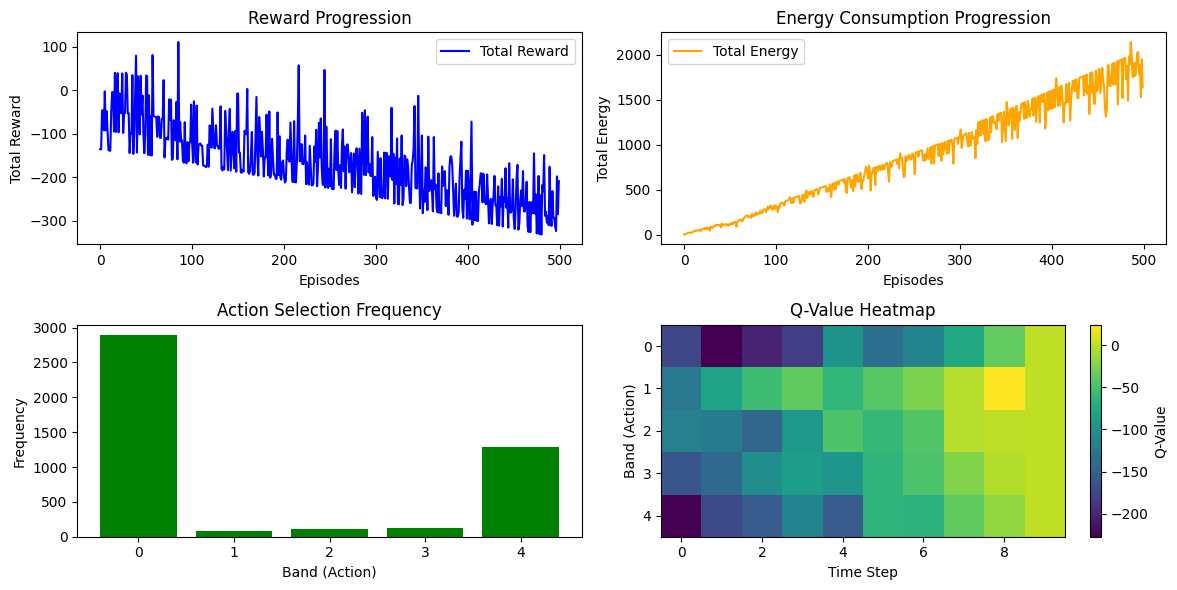

In [7]:
class QLearningAgentWithVisualization(QLearningAgent):
    def __init__(self, environment, alpha=0.2, gamma=0.95, epsilon=0.2, epsilon_decay=0.99, energy_penalty_factor=0.1):
        super().__init__(environment, alpha, gamma, epsilon)
        self.epsilon_decay = epsilon_decay
        self.energy_penalty_factor = energy_penalty_factor
        self.episode_rewards = []  # Track total rewards per episode
        self.episode_energy = []  # Track total energy consumption per episode
        self.action_counts = np.zeros(self.env.num_bands)  # Track action selection frequency

    def train(self, episodes):
        """
        Train the agent over multiple episodes with visualization tracking.
        
        Parameters:
        - episodes (int): Number of episodes to train the agent.
        """
        for episode in range(episodes):
            # Reset environment for each episode
            self.env._generate_spectrum_state()
            total_reward = 0
            total_energy = 0

            for time_step in range(self.env.steps - 1):
                state = (time_step,)

                # Choose an action (band)
                action = self.choose_action(state)
                self.action_counts[action] += 1  # Track action frequency

                # Calculate energy dynamically (decided by Q-learning)
                energy = self.env.energy_detection(time_step, action)
                total_energy += energy

                # Calculate the reward (penalize based on energy)
                raw_reward = self.env.step(time_step, action)
                reward = raw_reward - (energy * self.energy_penalty_factor)

                # Move to the next state
                next_state = (time_step + 1,)

                # Update Q-table
                self.update_q_table(state, action, reward, next_state)

                # Track the total reward
                total_reward += reward

            # Store metrics for visualization
            self.episode_rewards.append(total_reward)
            self.episode_energy.append(total_energy)

            # Decay epsilon for exploration vs exploitation
            self.epsilon = max(0.1, self.epsilon * self.epsilon_decay)

            print(f"Episode {episode + 1}/{episodes}: Reward = {total_reward}, Energy = {total_energy}")

    def visualize_results(self):
        """
        Visualize the results of training using matplotlib.
        """
        episodes = len(self.episode_rewards)

        # Plot Total Rewards per Episode
        plt.figure(figsize=(12, 6))
        plt.subplot(2, 2, 1)
        plt.plot(range(episodes), self.episode_rewards, label="Total Reward", color="blue")
        plt.xlabel("Episodes")
        plt.ylabel("Total Reward")
        plt.title("Reward Progression")
        plt.legend()

        # Plot Total Energy per Episode
        plt.subplot(2, 2, 2)
        plt.plot(range(episodes), self.episode_energy, label="Total Energy", color="orange")
        plt.xlabel("Episodes")
        plt.ylabel("Total Energy")
        plt.title("Energy Consumption Progression")
        plt.legend()

        # Plot Action Selection Frequency
        plt.subplot(2, 2, 3)
        plt.bar(range(self.env.num_bands), self.action_counts, color="green")
        plt.xlabel("Band (Action)")
        plt.ylabel("Frequency")
        plt.title("Action Selection Frequency")

        # Visualize Q-Value Evolution (Heatmap)
        plt.subplot(2, 2, 4)
        plt.imshow(self.q_table.T, aspect="auto", cmap="viridis", interpolation="nearest")
        plt.colorbar(label="Q-Value")
        plt.xlabel("Time Step")
        plt.ylabel("Band (Action)")
        plt.title("Q-Value Heatmap")

        plt.tight_layout()
        plt.show()


# Example Usage
env = SpectrumEnvironment(num_bands=5, steps=10)
agent = QLearningAgentWithVisualization(env)

# Train the agent
agent.train(episodes=500)

# Visualize the results
agent.visualize_results()


Episode 1/5000: Reward = 134.95000000000002, Epsilon = 0.995
Episode 2/5000: Reward = 134.91, Epsilon = 0.990025
Episode 3/5000: Reward = -45.209999999999994, Epsilon = 0.985074875
Episode 4/5000: Reward = -0.3200000000000127, Epsilon = 0.9801495006250001
Episode 5/5000: Reward = 89.62, Epsilon = 0.9752487531218751
Episode 6/5000: Reward = -0.5000000000000089, Epsilon = 0.9703725093562657
Episode 7/5000: Reward = 44.43000000000001, Epsilon = 0.9655206468094844
Episode 8/5000: Reward = 44.29, Epsilon = 0.960693043575437
Episode 9/5000: Reward = 134.14, Epsilon = 0.9558895783575597
Episode 10/5000: Reward = 224.29999999999998, Epsilon = 0.9511101304657719
Episode 11/5000: Reward = 89.1, Epsilon = 0.946354579813443
Episode 12/5000: Reward = 134.18, Epsilon = 0.9416228069143757
Episode 13/5000: Reward = 179.07, Epsilon = 0.9369146928798039
Episode 14/5000: Reward = -46.3, Epsilon = 0.9322301194154049
Episode 15/5000: Reward = 88.88, Epsilon = 0.9275689688183278
Episode 16/5000: Reward = 88

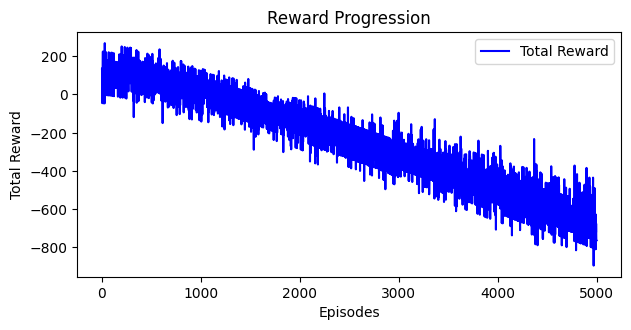

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque

class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)  # First hidden layer
        self.fc2 = nn.Linear(64, 64)  # Second hidden layer
        self.fc3 = nn.Linear(64, output_dim)  # Output layer (Q-values)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


class DQNAgent:
    def __init__(self, env, alpha=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, batch_size=32, memory_size=10000):
        self.env = env
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.epsilon_decay = epsilon_decay  # Decay rate of epsilon
        self.batch_size = batch_size  # Batch size for experience replay
        self.memory_size = memory_size  # Max size of experience replay buffer

        self.q_network = QNetwork(input_dim=1, output_dim=self.env.num_bands)  # Q-network
        self.target_network = QNetwork(input_dim=1, output_dim=self.env.num_bands)  # Target Q-network
        self.target_network.load_state_dict(self.q_network.state_dict())  # Initialize target network

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.alpha)  # Optimizer for the Q-network

        self.replay_buffer = deque(maxlen=self.memory_size)  # Experience replay buffer
        self.episode_rewards = []  # Track total rewards per episode

    def choose_action(self, state):
        """
        Choose an action based on epsilon-greedy policy.
        """
        if random.random() < self.epsilon:
            return random.randint(0, self.env.num_bands - 1)  # Exploration: random action
        else:
            state_tensor = torch.tensor([state], dtype=torch.float32)
            q_values = self.q_network(state_tensor)
            return torch.argmax(q_values).item()  # Exploitation: choose action with max Q-value

    def store_experience(self, state, action, reward, next_state):
        """
        Store experience in the replay buffer.
        """
        self.replay_buffer.append((state, action, reward, next_state))

    def sample_experience(self):
        """
        Sample a batch of experiences from the replay buffer.
        """
        return random.sample(self.replay_buffer, self.batch_size)

    def update_q_network(self):
        """
        Update Q-network using a batch of experiences.
        """
        if len(self.replay_buffer) < self.batch_size:
            return  # Not enough experiences to sample

        # Sample a batch from the replay buffer
        batch = self.sample_experience()

        # Separate batch into states, actions, rewards, next_states
        states, actions, rewards, next_states = zip(*batch)

        # Convert to tensors
        states_tensor = torch.tensor(states, dtype=torch.float32)
        actions_tensor = torch.tensor(actions, dtype=torch.int64)
        rewards_tensor = torch.tensor(rewards, dtype=torch.float32)
        next_states_tensor = torch.tensor(next_states, dtype=torch.float32)

        # Get Q-values for current states and next states
        q_values = self.q_network(states_tensor)
        next_q_values = self.target_network(next_states_tensor)

        # Get Q-value for chosen actions (action tensor is used as an index)
        q_value_for_actions = q_values.gather(1, actions_tensor.view(-1, 1)).squeeze(1)

        # Calculate target Q-values using the target network (Bellman equation)
        next_q_value_for_best_action = torch.max(next_q_values, dim=1)[0]
        target_q_values = rewards_tensor + self.gamma * next_q_value_for_best_action

        # Compute the loss (Mean Squared Error between predicted Q-values and target Q-values)
        loss = nn.MSELoss()(q_value_for_actions, target_q_values)

        # Update the Q-network weights
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def train(self, episodes=500):
        """
        Train the DQN agent.
        """
        for episode in range(episodes):
            self.env._generate_spectrum_state()  # Reset the environment
            total_reward = 0

            for time_step in range(self.env.steps - 1):
                state = (time_step,)

                # Choose an action
                action = self.choose_action(state)

                # Perform the action and get the reward
                energy = self.env.energy_detection(time_step, action)
                reward = self.env.step(time_step, action) - (energy * 0.1)

                # Get next state
                next_state = (time_step + 1,)

                # Store the experience in the replay buffer
                self.store_experience(state, action, reward, next_state)

                # Update the Q-network using the replay buffer
                self.update_q_network()

                total_reward += reward

            # Decay epsilon (exploration vs. exploitation)
            self.epsilon = max(0.1, self.epsilon * self.epsilon_decay)

            self.episode_rewards.append(total_reward)

            # Update the target network periodically
            if episode % 10 == 0:
                self.target_network.load_state_dict(self.q_network.state_dict())

            print(f"Episode {episode + 1}/{episodes}: Reward = {total_reward}, Epsilon = {self.epsilon}")

    def visualize_results(self):
        """
        Visualize the results of training using matplotlib.
        """
        episodes = len(self.episode_rewards)

        # Plot Total Rewards per Episode
        plt.figure(figsize=(12, 6))
        plt.subplot(2, 2, 1)
        plt.plot(range(episodes), self.episode_rewards, label="Total Reward", color="blue")
        plt.xlabel("Episodes")
        plt.ylabel("Total Reward")
        plt.title("Reward Progression")
        plt.legend()

        plt.tight_layout()
        plt.show()


# Example Usage
env = SpectrumEnvironment(num_bands=5, steps=10)
agent = DQNAgent(env)

# Train the agent
agent.train(episodes=5000)

# Visualize the results
agent.visualize_results()


In [12]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt

class SpectrumEnvironment:
    def __init__(self, num_bands=10, steps=25):
        self.num_bands = num_bands
        self.steps = steps
        self.channel_states = [[] for _ in range(num_bands)]
        self.transition_matrices = self._initialize_transition_matrices()
        self.state = self._generate_spectrum_state()
        self.total_reward = 0
        self.rewards = []
        self.energy_costs = [[0] * steps for _ in range(num_bands)]  # Initialize with zeros for all steps

    def _initialize_transition_matrices(self):
        matrices = []
        for _ in range(self.num_bands):
            random_matrix = np.random.rand(2, 2)
            transition_matrix = random_matrix / random_matrix.sum(axis=1, keepdims=True)
            matrices.append(transition_matrix)
        return matrices

    def _generate_spectrum_state(self):
        new_states = []
        for band in range(self.num_bands):
            last_state = self.channel_states[band][-1] if self.channel_states[band] else 0
            band_states = []
            for _ in range(self.steps):
                transition_probabilities = self.transition_matrices[band][last_state]
                next_state = np.random.choice([0, 1], p=transition_probabilities)
                band_states.append(next_state)
                last_state = next_state
            self.channel_states[band] = band_states
        return self.channel_states

    def energy_detection(self, time_step, band, delta=0.1):
        if time_step > 0:
            current_state = self.channel_states[band][time_step]
            previous_energy = self.energy_costs[band][time_step - 1]
            new_energy = previous_energy + delta if current_state == 1 else previous_energy
            self.energy_costs[band][time_step] = new_energy
        return self.energy_costs[band][time_step]

    def step(self, time_step, band):
        if not (0 <= band < self.num_bands) or not (0 <= time_step < self.steps):
            raise ValueError("Band number or time step out of range.")
        
        state = self.channel_states[band][time_step]
        reward = 30 if state == 0 else -15
        
        energy_penalty = 0.1 * self.energy_detection(time_step, band)
        total_reward = reward - energy_penalty
        self.total_reward += total_reward
        self.rewards.append(total_reward)
        return total_reward


class QNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


class DQNAgent:
    def __init__(self, env, input_size, output_size, learning_rate=0.0005, gamma=0.99, epsilon=1.0, epsilon_min=0.2, epsilon_decay=0.995, target_update_freq=10, batch_size=64, replay_buffer_size=10000):
        self.env = env
        self.input_size = input_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.target_update_freq = target_update_freq
        self.batch_size = batch_size
        self.replay_buffer_size = replay_buffer_size
        self.replay_buffer = deque(maxlen=self.replay_buffer_size)
        self.q_network = QNetwork(self.input_size, self.output_size)
        self.target_network = QNetwork(self.input_size, self.output_size)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.learning_rate)
        self.update_target_network()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randint(0, self.output_size - 1)
        state_tensor = torch.FloatTensor(np.array(state).flatten()).unsqueeze(0)  # Flatten state and convert to tensor
        q_values = self.q_network(state_tensor)
        return torch.argmax(q_values).item()

    def remember(self, state, action, reward, next_state, done):
        self.replay_buffer.append((state, action, reward, next_state, done))

    def replay(self):
        if len(self.replay_buffer) < self.batch_size:
            return
        minibatch = random.sample(self.replay_buffer, self.batch_size)
        for state, action, reward, next_state, done in minibatch:
            state_tensor = torch.FloatTensor(np.array(state).flatten()).unsqueeze(0)
            next_state_tensor = torch.FloatTensor(np.array(next_state).flatten()).unsqueeze(0)
            reward_tensor = torch.FloatTensor([reward])
            done_tensor = torch.FloatTensor([done])

            q_values = self.q_network(state_tensor)
            next_q_values = self.target_network(next_state_tensor)
            max_next_q_value = torch.max(next_q_values)
            target_q_value = reward_tensor + (self.gamma * max_next_q_value * (1 - done_tensor))

            loss = nn.MSELoss()(q_values[0][action], target_q_value)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

    def train(self, num_episodes=5000):
        rewards = []
        for episode in range(num_episodes):
            state = self.env._generate_spectrum_state()
            total_reward = 0
            for time_step in range(self.env.steps):
                band = self.act(state)
                reward = self.env.step(time_step, band)
                next_state = self.env.channel_states
                done = time_step == self.env.steps - 1
                self.remember(state, band, reward, next_state, done)
                self.replay()
                total_reward += reward
                state = next_state
            self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)
            if episode % self.target_update_freq == 0:
                self.update_target_network()
            rewards.append(total_reward)
            if episode % 100 == 0:
                print(f"Episode {episode}/{num_episodes} - Total Reward: {total_reward}")
        return rewards


# Initialize environment and agent
env = SpectrumEnvironment()
input_size = env.num_bands * env.steps
output_size = env.num_bands
agent = DQNAgent(env, input_size, output_size)

# Train the agent
num_episodes = 500
rewards = agent.train(num_episodes)

# Plot the results
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Reward Over Time')
plt.show()

Episode 0/5000 - Total Reward: 209.86000000000004


/home/ayush/Ayush/EE_Spectrum_Hole_Detection_with_RL/myenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
